# Single Observation Assimilation Analysis

Analyze the results of a single freeboard observation from ICESat-2 in CICE5, with emphasis on spatial and temporal "reach"

Work adapted from a notebook written by Prof. Cecilia Bitz at the University of Washington for a data assimilation tutorial at PWS 2018.

#### Plan for the notebook

1. Examine adjustments of ideal OSSE runs (plot with track on top!)
~ calculate innovations 
2. RMSE metric compared to free30 

### Load packages

In [1]:
import xarray as xr
import matplotlib
import numpy as np
import os
import re
# import dask
# from dask.distributed import Client
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotting_utils as plu
# from scipy import stats, signal
# import xskillscore as xs
from sklearn import metrics

#import plotting_utils as plu

#magic for plots to show up below cells
%matplotlib inline

### Set paths

In [2]:
user = 'mollyw'
user_path = '/glade/scratch/' + user + '/'
work_path = '/glade/work/' + user + '/DA_analysis'
time_path = '/ice/proc/tseries/day_1/'

# Case List- assimilation
DA_grid = 'DA30_010_grid'
DA_grid2 = 'DA30_010_grid_ni200_sic'
DA_circ = 'DA30_010_grid_circle'
DA_opcheck = 'DA30_010_grid_opcheck'
DA_gridh = 'DA30_010_higrid'
DA_gridh2 = 'DA30_010_higrid_ni200'
DA_circh = 'DA30_010_higrid_circle'
# Case List- no assimilation
free = 'free30'

In [3]:
exp1 = [DA_grid,DA_opcheck, DA_gridh, DA_grid2,DA_gridh2,DA_circ, DA_circh, free] # DA_grid2,DA_gridh2,
tags = ["GRID","GRIDOP","HIGRID","GRID200","HIGRID200","CIRC","HICIRC","FREE"] #,"GRID200","HIGRID200",
EXPERIMENT1={}
# Work on generalizing this for all kinds of experiments 
# Also considering doing this through mfdataset?
count = 0
for x in exp1:
    data_file = glob.glob(user_path + 'archive/' + x + time_path + x +'.cice.h.hi.2019*[0-9]*')
    
    # Trim
    DATA = xr.open_dataset(data_file[0]).sel(time = slice('2019-04-15', '2019-07-01'))
    
    # Load 
    EXPERIMENT1[tags[count]] = DATA
#     print(tags[count])
    # Advance 
    count += 1

truth_files = glob.glob(user_path + 'archive/'+free+'/ice/hist_perfect/'+ free +'.cice_0024.h.2019*[0-9]*')
TRUTH = xr.open_mfdataset(truth_files, concat_dim = 'time').sel(time = slice('2019-04-15', '2019-07-01'))
EXPERIMENT1["TRUTH"] = TRUTH

track = xr.open_dataset('perfect_freeboard.nc')
track_circle = xr.open_dataset('perfect_freeboard_circle.nc')
track_ni200 = xr.open_dataset('perfect_freeboard_ni200.nc')
track_opcheck = xr.open_dataset('perfect_freeboard_opcheck.nc')


In [4]:
ds_FBgrid= EXPERIMENT1["GRID200"]
ds_THgrid = EXPERIMENT1["HIGRID200"]
ds_free = EXPERIMENT1["FREE"]
ds_truth = EXPERIMENT1["TRUTH"]

RMSE_freeboard = []
RMSE_thickness = []

day = 5
# for day in range(1,len(ds_FBgrid.time):
i = len(ds_FBgrid.time[0:day])
x1 = ds_FBgrid.hi.isel(time=slice(0,i))
x2 = ds_THgrid.hi.isel(time=slice(0,i))
x3 = ds_free.hi.isel(time=slice(0,i))
y = ds_truth.hi.isel(time=slice(0,i))
    
# thing = xs.rmse(x1, y, dim = 'time') 
# thing2 = xs.rmse(x2, y, dim = 'time')

# thing = metrics.mean_squared_error(y, x1, sample_weight=None, multioutput='uniform_average', squared=False)
    
thing = np.sqrt(sum((x1 - y)**2)/len(ds_truth.time[0:i])) #
thing2 = np.sqrt(sum((x2 - y)**2)/len(ds_truth.time[0:i]))
thing3 = np.sqrt(sum((x3 - y)**2)/len(ds_truth.time[0:i]))
RMSE_freeboard.append(thing)
RMSE_thickness.append(thing2)
    
RMSE_FR= xr.concat(RMSE_freeboard, dim='time')
RMSE_TH= xr.concat(RMSE_thickness, dim='time')  

### MAB

In [5]:
MAB_free = sum((ds_free.hi - ds_truth.hi))/len(ds_truth)
# MAB_dfb = sum(xr.ufuncs.fabs(ds_dass.aice - ds_truth.aice)/len(ds_truth))
# MAB_dth = sum(xr.ufuncs.fabs(ds_noise.aice - ds_truth.aice)/len(ds_truth))


# x3 = ds_dass.aice
# y1 = ds_truth.aice
# RMSE_dass = np.sqrt(sum((x3- y1)**2)/len(y1))

# SUB = RMSE_dass - MAB_dfb

In [16]:
SUB.load()

<xarray.DataArray 'hi' (nj: 384, ni: 320)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.3531039 , -0.12211874, -0.04837504, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
    TLON     (nj, ni) float32 320.5625 321.6875 322.8125 ... 319.35068 319.7835
    TLAT     (nj, ni) float32 -79.22052 -79.22052 ... 72.18933 72.185974
    ULON     (nj, ni) float32 321.125 322.25 323.375 ... 319.58603 320.0
    ULAT     (nj, ni) float32 -78.952896 -78.952896 ... 72.41355 72.411934
    time     object 2019-07-14 00:00:00
Dimensions without coordinates: nj, ni

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Text(0.5, 0.98, 'Mean Bias, SIC, FREE vs Mem24')

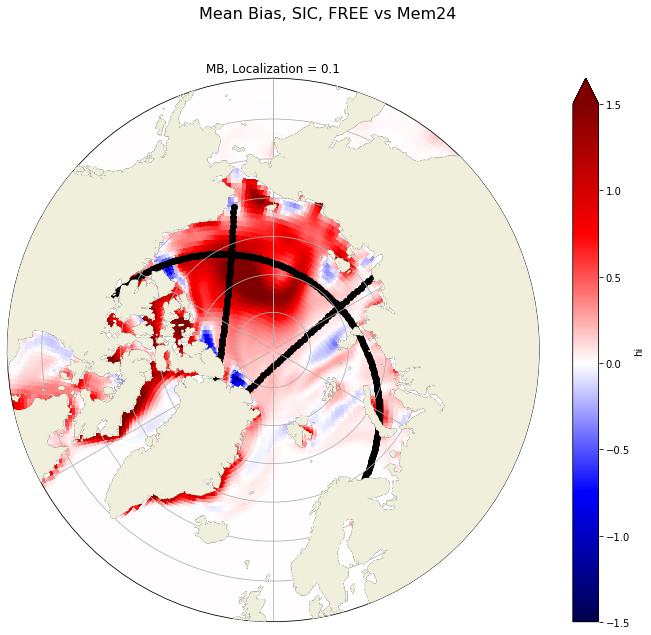

In [6]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
onPOPgrid=MAB_free
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax, vmin = -1.5, vmax = 1.5, transform=ccrs.PlateCarree(), cmap=plt.cm.seismic) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
xr.plot.scatter(track, x = 'lon', y = 'lat', c = 'k', transform = ccrs.PlateCarree())  # vmin = 0, vmax = 0.1,
xr.plot.scatter(track_ni200, x = 'lon', y = 'lat', c = 'k',  transform = ccrs.PlateCarree())
xr.plot.scatter(track_circle, x = 'lon', y = 'lat', c = 'k', transform = ccrs.PlateCarree())
plt.title('MB, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('Mean Bias, SIC, FREE vs Mem24',fontsize =16)
# plt.tight_layout()
   


### RMSE

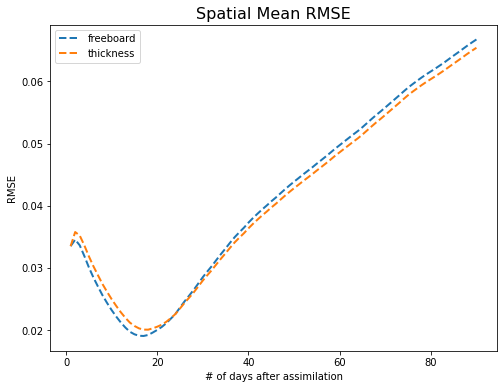

In [48]:
fig = plt.figure(figsize = (8,6))
plt.plot(RMSE_fr,'--', linewidth = 2, label = 'freeboard')
plt.plot(RMSE_th,'--', linewidth = 2, label = 'thickness')
# plt.scatter(ds_dass.time, ds_dass.RMSE, 'k+')
plt.title("Spatial Mean RMSE", fontsize = 16)
plt.ylabel('RMSE')
plt.xlabel('# of days after assimilation')
# plt.ylim([0.017, 0.021])
plt.legend()

In [75]:
track = track.where(track.freeboard > 0)
track_noisy = track_noisy.where(track_noisy.thickness > 0)

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Text(0.5, 0.98, 'Freeboard OSSE, Day 5')

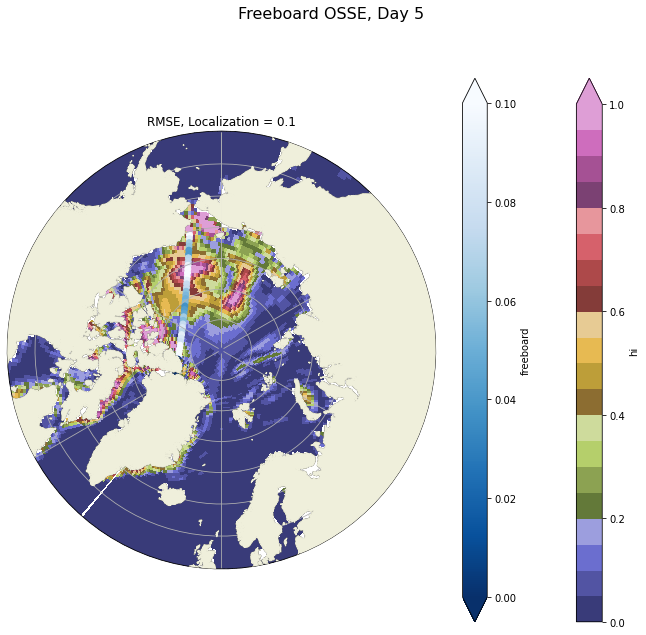

In [37]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
onPOPgrid=thing
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax, vmin = 0, vmax = 1, transform=ccrs.PlateCarree(), cmap=plt.cm.tab20b) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
xr.plot.scatter(track_ni200, x = 'lon', y = 'lat', hue = 'freeboard', vmin = 0, vmax = 0.1, transform = ccrs.PlateCarree(), cmap = cm.Blues_r)
plt.title('RMSE, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
plt.suptitle('Freeboard OSSE, Day ' + str(day),fontsize =16)
# plt.tight_layout()
   


In [38]:
track_ni200_th = xr.open_dataset('perfect_thickness_ni200.nc')

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


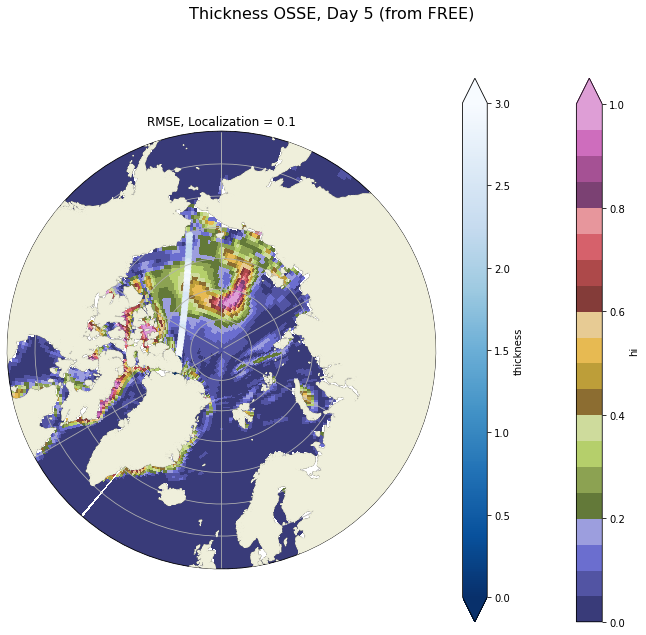

In [39]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
onPOPgrid=thing2
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax, vmin = 0, vmax = 1, transform=ccrs.PlateCarree(), cmap=plt.cm.tab20b) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
xr.plot.scatter(track_ni200_th, x = 'lon', y = 'lat', hue = 'thickness', vmin = 0, vmax = 3, ax = ax, transform = ccrs.PlateCarree(), cmap = cm.Blues_r)
plt.title('RMSE, Localization = 0.1')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off

plt.suptitle('Thickness OSSE, Day '  + str(day) + ' (from FREE)' ,fontsize =16)
plt.tight_layout()

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


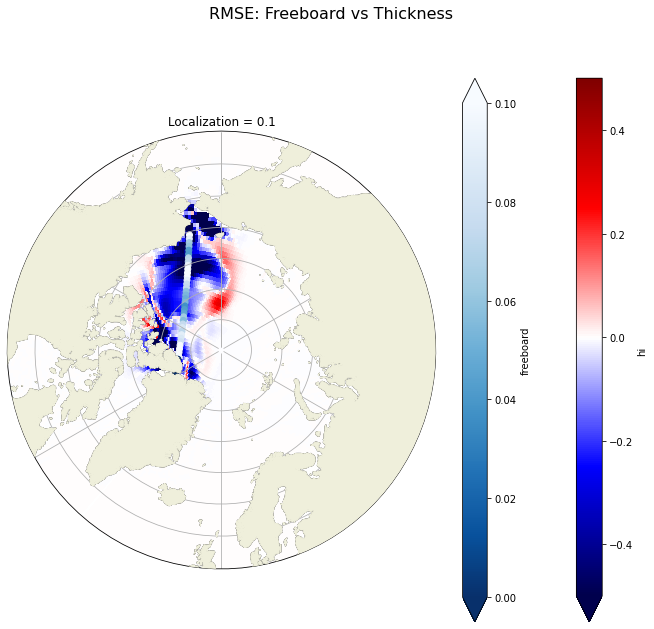

In [41]:
f=plt.figure(figsize=(12,10))
# for t in ds_free.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
onPOPgrid=thing2-thing
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
    
onPOPgrid.ULAT[:]=grid.lat
onPOPgrid.ULON[:]=grid.lon
#     onPOP1D=onPOPgrid.stack(n_s=('nj','ni'))
#     ongrid2=numpy.zeros(Ntot)
#     ongrid2[dst]=numpy.multiply(Tr.S.values,onPOP1D[src].values)
#     with numpy.errstate(divide='ignore', invalid='ignore'):
#         ongrid2=numpy.divide(ongrid2,totwts)
#     onPMgrid=numpy.reshape(ongrid2,(Tr.dst_grid_dims[1].values,Tr.dst_grid_dims[0].values))
    
    
#     tmp=numpy.flipud(onPMgrid.T)
#     # the land is nan which by default has color of zero so change it to a large negative 
#     tmp[numpy.isnan(tmp)]=-999.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

ax=plt.subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=6)
    
onPOPgrid.plot.pcolormesh('ULON', 'ULAT', ax=ax, vmin = -0.5, vmax = 0.5, transform=ccrs.PlateCarree(), cmap=plt.cm.seismic) #vmax = 0.05,
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
xr.plot.scatter(track_ni200, x = 'lon', y = 'lat', hue = 'freeboard', vmin = 0, vmax = 0.1, ax = ax, transform = ccrs.PlateCarree(), cmap = cm.Blues_r)
plt.title('Localization = 0.1')
plt.suptitle('RMSE: Freeboard vs Thickness', fontsize= 16)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,labelleft=False) # labels along the bottom edge are off
   
plt.tight_layout()

# 3. Timescale Assimilation Cookie Sheets

In [ ]:
# Lots of work to be done here ... 

/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/mollyw/mmw_npl/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


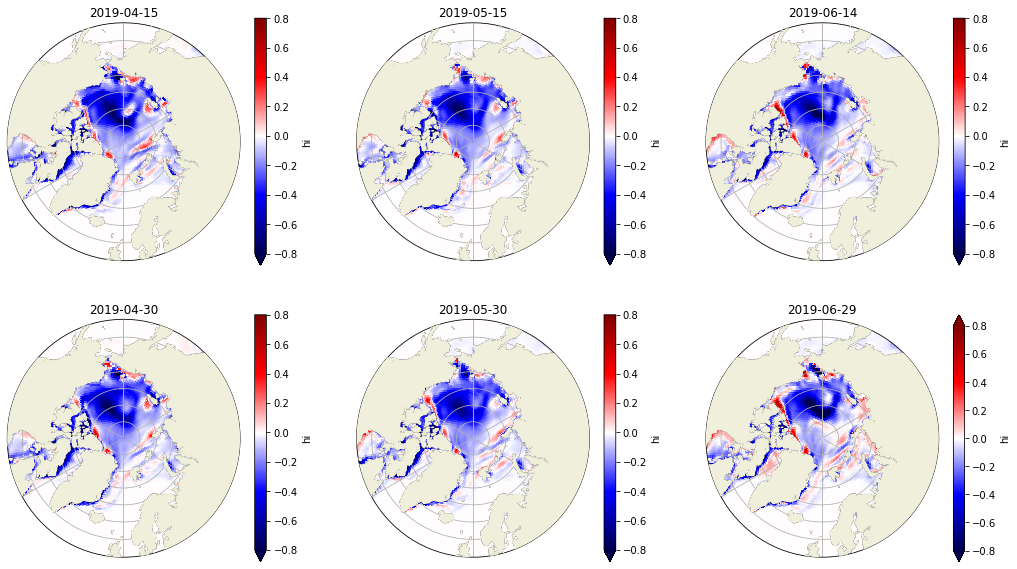

In [22]:
# Ensemble means
# Now plot differences of the DA run minus the free run
# in a loop to do it every 15 days, starting a few days after the first DA step
f=plt.figure(figsize=(24,10))
gs=GridSpec(2,4)
counter=0
grid1=0
grid2=0
grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
for t in ds_THgrid.time[::15]:
# nj=slice(280,ds_slfr.nj.size)
    onPOPgrid=ds_THgrid.hi.sel(time=t)-ds_truth.hi.sel(time=t)-MAB_free
    
    onPOPgrid.TLAT[:]=grid.lat
    onPOPgrid.TLON[:]=grid.lon
    
    if counter/2 == grid2+1:
        grid2 = grid2+1
        grid1 = 0

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)

    ax=plt.subplot(gs[grid1,grid2], projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.gridlines()
    ax.coastlines()
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=6)
    
    onPOPgrid.plot.pcolormesh('TLON', 'TLAT', ax=ax, vmin = -0.8, vmax = 0.8,transform=ccrs.PlateCarree(), cmap=plt.cm.seismic)
#     xr.plot.scatter(track, x = 'lon', y = 'lat', hue = 'freeboard', vmin = 0, vmax = 0.8, ax = ax, transform = ccrs.PlateCarree(), cmap = cm.Blues)
#     hnd=plt.pcolor(tmp, vmin=-.2, vmax=.2, cmap=plt.cm.seismic)
#     plt.ylim([110, 330])
    newt=str(t.values)
    plt.title(newt[0:10])
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False,labelleft=False) # labels along the bottom edge are off
        
    counter=counter+1
    grid1=grid1+1

plt.tight_layout()
# plt.colorbar()    


Text(0.5, 1.0, 'Spatial mean SIT, spring forecast')

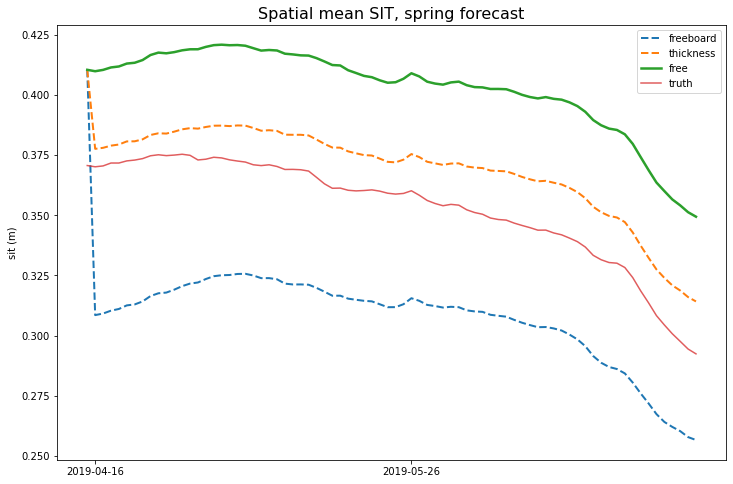

In [16]:
fig = plt.figure(figsize = (12,8)) 
plt.plot(ds_FBgrid.time, ds_FBgrid.hi.sel(ni = 200).mean(dim='nj'),'--', linewidth = 2, label = 'freeboard') #.where(ds_FBgrid.hi > 1e-12)
plt.plot(ds_THgrid.time,ds_THgrid.hi.sel(ni = 200).mean(dim ='nj'),'--', linewidth = 2, label= 'thickness')
plt.plot(ds_free.time, ds_free.hi.sel(ni = 200).mean(dim='nj'), linewidth = 2.5, label = 'free')
plt.plot(ds_truth.time,ds_truth.hi.sel(ni = 200).mean(dim = 'nj'), markersize = 3, alpha = 0.75, label = 'truth')
plt.ylabel('sit (m)')
plt.legend()
plt.title('Spatial mean SIT, spring forecast',fontsize = 16)

Text(0.5, 1.0, 'Spatial mean SIT, spring forecast')

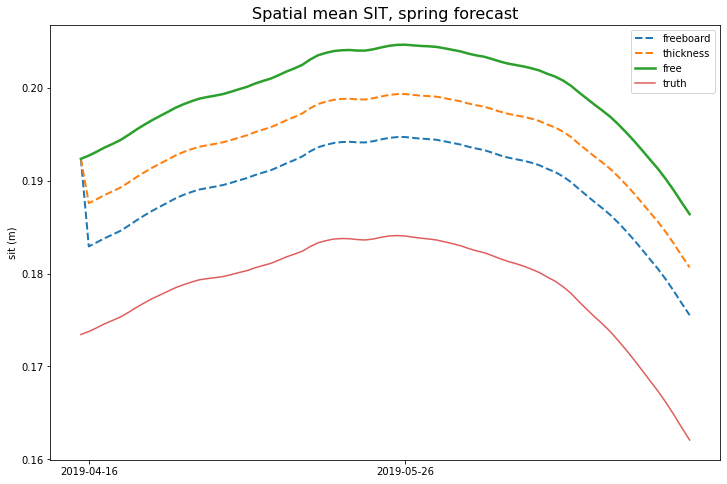

In [17]:
fig = plt.figure(figsize = (12,8)) 
plt.plot(ds_FBgrid.time, ds_FBgrid.hi.mean(dim=['ni','nj']),'--', linewidth = 2, label = 'freeboard')
plt.plot(ds_THgrid.time,ds_THgrid.hi.mean(dim=['ni','nj']),'--', linewidth = 2, label= 'thickness')
plt.plot(ds_free.time, ds_free.hi.mean(dim=['ni','nj']), linewidth = 2.5, label = 'free')
plt.plot(ds_truth.time,ds_truth.hi.mean(dim=['ni','nj']), markersize = 3, alpha = 0.75, label = 'truth')
plt.ylabel('sit (m)')
plt.legend()
plt.title('Spatial mean SIT, spring forecast',fontsize = 16)

### OLD CODE

In [ ]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  numpy.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*numpy.sqrt(n-2)/numpy.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [ ]:
a, b, mar_regs, c, d, i = lag_linregress_3D(ds_march_area.aice*100, ds_march_area.hi)
e, f, sep_regs, g, h, j = lag_linregress_3D(ds_sept_area.aice*100, ds_sept_area.hi)

In [ ]:
mar_regs.load()
sep_regs.load()

grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')


mar_regs.TLAT[:] = grid.lat
mar_regs.TLON[:] = grid.lon

sep_regs.TLAT[:] = grid.lat
sep_regs.TLON[:] = grid.lon

In [ ]:
ds_march_area = ds_march.where(ds_march.aice > 0.15)
ds_sept_area = ds_sept.where(ds_sept.aice > 0.15)

In [ ]:
mar_sig = d
sep_sig = h

mar_inds = mar_sig.TLAT.where(mar_sig < 0.05)
sep_inds = sep_sig.TLAT.where(mar_sig < 0.05)

In [ ]:
theta = numpy.linspace(0, 2*numpy.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = numpy.vstack([numpy.sin(theta), numpy.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

fig= plt.figure(figsize=(20,8))
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.gridlines()
ax1.coastlines()
#ax1.add_feature(cfeature.LAND,zorder=6)
mar_regs.plot.pcolormesh('TLON','TLAT', transform=ccrs.PlateCarree(), cmap = 'RdBu_r',vmin = -3, vmax = 3)#where(mar_regs.TLAT == mar_inds)
plt.title('march',fontsize=16, fontweight='bold')

ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.gridlines()
ax2.coastlines()
#ax2.add_feature(cfeature.LAND,zorder=6)
sep_regs.plot.pcolormesh('TLON','TLAT', transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = -3, vmax = 3) #where(sep_regs.TLAT == sep_inds).
plt.title('september', fontsize=16, fontweight='bold')

plt.suptitle('time dependent regression of sea-ice variables', fontweight='bold',fontsize=20)
theta = numpy.linspace(0, 2*numpy.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = numpy.vstack([numpy.sin(theta), numpy.cos(theta)]).T
circle = matplotlib.path.Path(verts * radius + center)

fig= plt.figure(figsize=(20,8))
ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.gridlines()
ax1.coastlines()
#ax1.add_feature(cfeature.LAND,zorder=6)
mar_regs.plot.pcolormesh('TLON','TLAT', transform=ccrs.PlateCarree(), cmap = 'RdBu_r',vmin = -3, vmax = 3)#where(mar_regs.TLAT == mar_inds)
plt.title('march',fontsize=16, fontweight='bold')

ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())
ax2.set_extent([-180,180,55,90], ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.gridlines()
ax2.coastlines()
#ax2.add_feature(cfeature.LAND,zorder=6)
sep_regs.plot.pcolormesh('TLON','TLAT', transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = -3, vmax = 3) #where(sep_regs.TLAT == sep_inds).
plt.title('september', fontsize=16, fontweight='bold')

plt.suptitle('time dependent regression of sea-ice variables', fontweight='bold',fontsize=20)


In [ ]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(1,2,1)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left=False,         # ticks along the top edge are off
    labelbottom=False)
c = ax1.pcolor(mar_regs.where(abs(mar_regs) < 1), cmap = 'RdBu')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2 = plt.subplot(1,2,2)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,  
    left=False,         # ticks along the top edge are off
    labelbottom=False)
c2 = ax2.pcolor(sep_regs.where(abs(sep_regs) < 1), cmap = 'RdBu')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.suptitle('time-varying correlation of sea ice variables', fontweight='bold',fontsize=16)
fig.colorbar(c, ax=ax1)
fig.colorbar(c2, ax=ax2)

In [ ]:
vol_case_nh=ds_case.hi.isel(nj=slice(350,380),ni=slice(110,220)).mean(dim=['nj','ni']).values #for time mean use this : isel(nj=slice(367,377),ni=slice(98,108)).mean(dim=['nj','ni'])
# vol_free_nh=ds_slfr.hi.isel(nj=slice(367,377),ni=slice(98,108)).mean(dim=['nj','ni']).values
vol_free_nh=ds_free.hi.isel(nj=slice(350,380),ni=slice(110,220)).mean(dim=['nj','ni']).values

# (367,377),ni=slice(98,108)

time = 1 #214 for b cases #261
#change to this once there is a noticeable time series
hnd=plt.scatter(time, vol_free_nh, time, vol_case_nh)#ds_free.time[::5],NHvolume2[::5],'.')

#plt.scatter(ds_case.TLAT.values,vol_free_nh, marker ='.')
#plt.scatter(ds_case.TLAT.values,vol_case_nh, marker ='.')
plt.legend(['Free Run','DA Run'])
plt.title('Northern Hemisphere Sea Ice Volume')
plt.xticks(rotation=50)
print('First assimilation step is at second green dot, check slices if no blue line.\nIf the lines are equal, check your slice.')